In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

from tqdm import tqdm
import numpy as np
import random
# 하이퍼파라미터 설정
batch_size = 128
epochs = 74
learning_rate = 1e-3
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 전처리 및 로드

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG의 입력 크기(224x224)로 조정
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261]), 
])

# 전체 데이터셋 로드(CIFAR10)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# 데이터셋 크기 확인
print(f"Train dataset size: {len(trainset)}")
print(f"Test dataset size: {len(testset)}")

# 첫 번째 배치 확인 (이미지와 라벨)
images, labels = next(iter(trainloader))
print(f"Batch image shape: {images.shape}")  # (batch_size, channels, height, width)
print(f"Batch labels: {labels[:5]}")  # 첫 5개 라벨 확인

100%|██████████| 170M/170M [00:03<00:00, 47.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train dataset size: 50000
Test dataset size: 10000
Batch image shape: torch.Size([128, 3, 224, 224])
Batch labels: tensor([6, 4, 8, 3, 5])


# VGG16 모델 정의
- 아래 명시되어 있는 A-E의 모델 중 D에 해당하는 모델의 구조를 구현
- C는 1X1 filter가 중간에 끼여있고, D는 해당 filter를 3X3으로 구성
- 원래 1X1 Conv의 역할은 채널 수를 줄이는 역할인데, 아래 표를 보면 3X3으로 구성했을 때와 output channel수가 같음
    - 해당 논문에서는 층을 깊게해서 비선형성을 더 추가하기 위한 목적으로 사용됨         

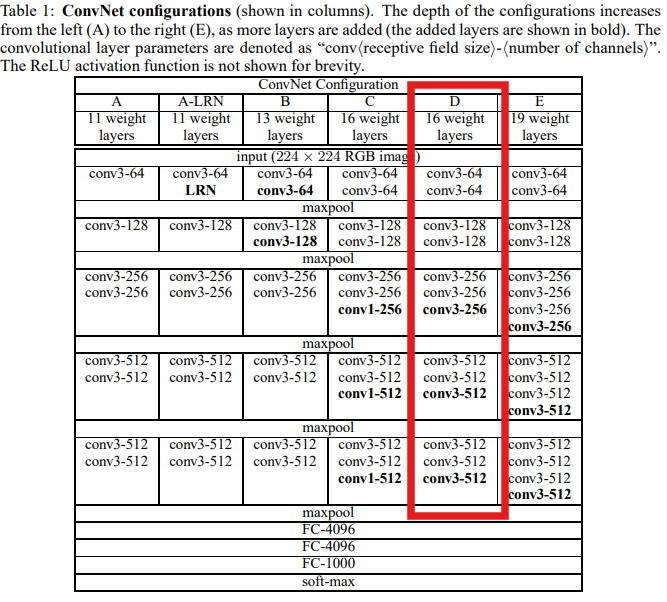

- C에 비해서 D의 성능이 좋기 때문에 D로 구현

- A-LRN이 보이는데, 해당 논문에서는 LRN이 ILSVRC dataset에서 효과적이지도 않고 메모리와 계산 시간만 많이 잡아먹는다고 평가함
    - 그렇다고 따로 Normalization을 사용하지는 않음 

위의 표를 시각화했을 때 다음과 같은 모델 아키텍처를 구성하게 된다.

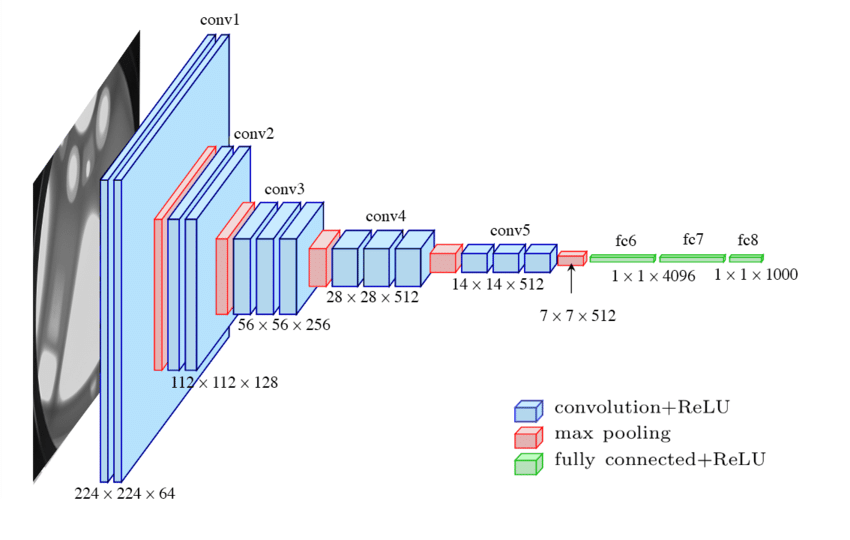

- Conv block은 크게 5개의 block으로 구분지을 수 있다.
    - 굳이 Conv block을 구분지은 이유는 같은 Conv block에서는 input, output의 feature map 사이즈가 같가 때문이다.
        - 이 부분은 사이즈 1짜리의 padding을 주는 것으로 구현 
    - 따라서 같은 block에서는 spatial resolution(공간해상도)이 일정하게 유지되도록 했다. 
- fc block은 크게 3개의 block으로 구분지을 수 있다.
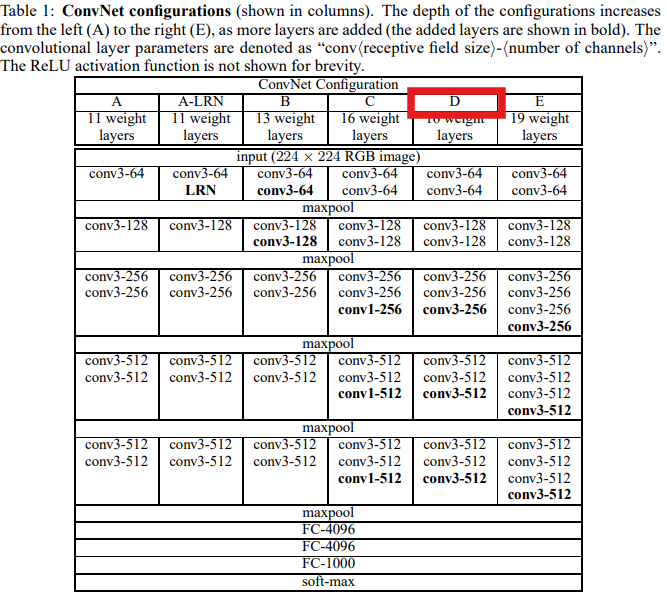
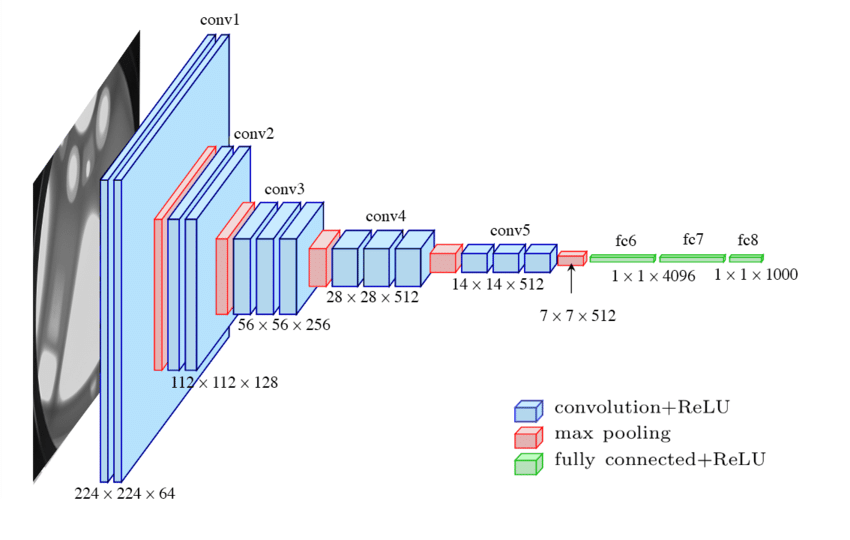

In [3]:
# import torch
# import torch.nn as nn

# class VGGNet(nn.Module):
#     def __init__(self, num_classes=1000, dropout: float = 0.5):
#         super(VGGNet, self).__init__()
        
#         self.features = nn.Sequential(
#             # Conv Block 1
#             nn.Conv2d(3, 64, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, 64, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
            
#             # Conv Block 2
#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(128, 128, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
            
#             # Conv Block 3
#             nn.Conv2d(128, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
            
#             # Conv Block 4
#             nn.Conv2d(256, 512, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
            
#             # Conv Block 5
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )
        
#         self.classifier = nn.Sequential(
#             nn.Linear(512 * 7 * 7, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=dropout),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=dropout),
#             nn.Linear(4096, num_classes)
#         )
    
#     def forward(self, x):
#         x = self.features(x)
#         x = torch.flatten(x, 1)
#         x = self.classifier(x)
#         return x

## VGG16 구조 확인

In [4]:
# import torchsummary
# model = VGGNet(num_classes = 10).to(device) # 데이터 셋의 클래스 수 : 10개

# torchsummary.summary(model, input_size=(3, 224, 224), device='cuda')

# VGG16+Batchnorm 추가
- 추론 시에는 batchnorm을 꺼야하는 것으로 알고 있는데, nn.BatchNorm2d에서는 eval 모드일 경우 자동으로 꺼진다고 함

In [5]:
# import torch
# import torch.nn as nn

# class VGG_with_BN(nn.Module):
#     def __init__(self, num_classes=1000):
#         super(VGG_with_BN, self).__init__()
        
#         self.features = nn.Sequential(
#             # Conv Block 1
#             nn.Conv2d(3, 64, kernel_size=3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, 64, kernel_size=3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
            
#             # Conv Block 2
#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(128, 128, kernel_size=3, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
            
#             # Conv Block 3
#             nn.Conv2d(128, 256, kernel_size=3, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
            
#             # Conv Block 4
#             nn.Conv2d(256, 512, kernel_size=3, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
            
#             # Conv Block 5
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )
        
#         self.classifier = nn.Sequential(
#             nn.Linear(512 * 7 * 7, 4096),
#             nn.BatchNorm1d(4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(4096, 4096),
#             nn.BatchNorm1d(4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(4096, num_classes)
#         )
    
#     def forward(self, x):
#         x = self.features(x)
#         x = torch.flatten(x, 1)
#         x = self.classifier(x)
#         return x

## VGG16+batchnorm 구조 확인

In [6]:
# import torchsummary
# model = VGG_with_BN(num_classes = 10).to(device) # 데이터 셋의 클래스 수 : 10개

# torchsummary.summary(model, input_size=(3, 224, 224), device='cuda')

# VGG11 모델 정의

In [7]:
import torch
import torch.nn as nn

class VGG11(nn.Module):
    def __init__(self, num_classes=1000, dropout: float = 0.5):
        super(VGG11, self).__init__()
        
        self.features = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## VGG11 구조 확인

In [8]:
import torchsummary
model = VGG11(num_classes = 10).to(device) # 데이터 셋의 클래스 수 : 10개

torchsummary.summary(model, input_size=(3, 224, 224), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5        [-1, 128, 112, 112]          73,856
       BatchNorm2d-6        [-1, 128, 112, 112]             256
              ReLU-7        [-1, 128, 112, 112]               0
         MaxPool2d-8          [-1, 128, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         295,168
      BatchNorm2d-10          [-1, 256, 56, 56]             512
             ReLU-11          [-1, 256, 56, 56]               0
           Conv2d-12          [-1, 256, 56, 56]         590,080
      BatchNorm2d-13          [-1, 256, 56, 56]             512
             ReLU-14          [-1, 256,

# 손실 함수, 옵티마이저, lr scheduler 설정

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, params=model.parameters(), lr=learning_rate)

# adjust learning rate: validation error가 현재 lr로 더 이상 개선 안되면 lr을 10으로 나눠줌. 논문에서는 0.01을 lr 초기 값으로 총 3번 줄어듦
# factor : lr 업데이트 시 lr = lr*factor로 계산됨
# patience : 검증 손실값이 개선되지 않은 상태를 얼마나 허용할 것인지를 설정하는 정수값. 기본값은 10으로, 10번의 연속적인 epoch 동안 검증 손실값이 개선되지 않으면 learning rate를 감소시킴
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.1, verbose=True, patience=4) # used if valid error doesn't improve.

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# train

In [10]:
def train(model, data_loader, loss_fn, optimizer, device):
    model.train()
    running_loss = 0.0
    corr = 0.0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        
        # 누적 Gradient 초기화
        optimizer.zero_grad()

        # forward
        outputs = model(images)

        # loss
        loss_fn = criterion(outputs, labels)
        # backward
        loss_fn.backward()
        # Gradient 업데이트 
        optimizer.step()
        # 누적 loss 업데이트
        running_loss += loss_fn.item()*images.size(0) # 배치 전체 loss 계산
        # max probability와 max index를 반환
        # max index만 사용해서 실제 정답과 비교
        _, pred = torch.max(outputs, 1)
        # 정확히 맞춘 label의 합계를 계산
        corr += pred.eq(labels).sum().item()
    
    # 누적된 정답수를 전체 개수로 나누어 전체 정확도 계산
    acc = corr / len(data_loader.dataset)
    
    # 전체 loss와 전체 accuracy 반환
    # train_loss, train_acc
    return running_loss / len(data_loader.dataset), acc

# test

In [11]:
# 테스트 루프
def test(model, data_loader, loss_fn, device):
    model.eval()
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수
        corr = 0.0
        running_loss = 0.0
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            corr += (predicted == labels).sum().item()
            running_loss += loss_fn(outputs, labels).item() * images.size(0)
    acc = corr / len(data_loader.dataset)
    return running_loss / len(data_loader.dataset), acc

# Evaluation

In [12]:
min_loss = np.inf
MODEL_NAME = "VGG16_best"
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

# Early stopping 설정
patience = 5  # val_loss 개선되지 않는 최대 epoch 수
early_stop_counter = 0  # 개선되지 않은 epoch 수

# Epoch 별 train & test
for epoch in tqdm(range(epochs)):
    # Model Training
    # train result
    train_loss, train_acc = train(model, trainloader, criterion, optimizer, device)

    # validation result
    val_loss, val_acc = test(model, testloader, criterion, device)   
    
    # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장
    if val_loss < min_loss:
        print(f'[INFO] val_loss has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
        min_loss = val_loss
        torch.save(model.state_dict(), f'{MODEL_NAME}.pth')
        early_stop_counter = 0 # 개선되었으므로 early stopping counter 리셋
    else:
        early_stop_counter += 1 # 개선되지 않았으면 카운터 증가

    # learning rate update
    lr_scheduler.step(metrics=val_loss)
    
    # Epoch 별 결과
    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')
    # 결과 저장
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    
    # Early stopping
    if early_stop_counter >= patience:
        print(f'Early stopping at epoch {epoch}...')
        break

  1%|▏         | 1/74 [04:00<4:52:09, 240.13s/it]

[INFO] val_loss has been improved from inf to 1.17078. Saving Model!
epoch 01, loss: 1.51764, acc: 0.45400, val_loss: 1.17078, val_accuracy: 0.58890
[INFO] val_loss has been improved from 1.17078 to 0.94492. Saving Model!


  3%|▎         | 2/74 [07:59<4:47:50, 239.87s/it]

epoch 02, loss: 1.08527, acc: 0.61812, val_loss: 0.94492, val_accuracy: 0.66390
[INFO] val_loss has been improved from 0.94492 to 0.78313. Saving Model!


  4%|▍         | 3/74 [11:59<4:44:00, 240.01s/it]

epoch 03, loss: 0.87227, acc: 0.69622, val_loss: 0.78313, val_accuracy: 0.73290
[INFO] val_loss has been improved from 0.78313 to 0.74188. Saving Model!


  5%|▌         | 4/74 [15:59<4:39:55, 239.93s/it]

epoch 04, loss: 0.73219, acc: 0.74460, val_loss: 0.74188, val_accuracy: 0.74180
[INFO] val_loss has been improved from 0.74188 to 0.68170. Saving Model!


  7%|▋         | 5/74 [20:00<4:36:08, 240.12s/it]

epoch 05, loss: 0.62660, acc: 0.78456, val_loss: 0.68170, val_accuracy: 0.76170
[INFO] val_loss has been improved from 0.68170 to 0.65348. Saving Model!


  8%|▊         | 6/74 [24:00<4:32:10, 240.16s/it]

epoch 06, loss: 0.52202, acc: 0.82122, val_loss: 0.65348, val_accuracy: 0.77400
[INFO] val_loss has been improved from 0.65348 to 0.61013. Saving Model!


  9%|▉         | 7/74 [28:00<4:28:13, 240.21s/it]

epoch 07, loss: 0.44474, acc: 0.84878, val_loss: 0.61013, val_accuracy: 0.79030


 11%|█         | 8/74 [32:00<4:24:10, 240.15s/it]

epoch 08, loss: 0.36478, acc: 0.87574, val_loss: 0.64184, val_accuracy: 0.79060
[INFO] val_loss has been improved from 0.61013 to 0.58795. Saving Model!


 12%|█▏        | 9/74 [36:01<4:20:16, 240.25s/it]

epoch 09, loss: 0.29144, acc: 0.90340, val_loss: 0.58795, val_accuracy: 0.80220


 14%|█▎        | 10/74 [40:01<4:16:15, 240.25s/it]

epoch 10, loss: 0.23449, acc: 0.92322, val_loss: 0.70505, val_accuracy: 0.77740


 15%|█▍        | 11/74 [44:01<4:12:04, 240.08s/it]

epoch 11, loss: 0.18000, acc: 0.94234, val_loss: 0.67297, val_accuracy: 0.79080


 16%|█▌        | 12/74 [48:01<4:08:05, 240.09s/it]

epoch 12, loss: 0.14853, acc: 0.95442, val_loss: 0.63682, val_accuracy: 0.80440


 18%|█▊        | 13/74 [52:01<4:04:05, 240.09s/it]

epoch 13, loss: 0.11175, acc: 0.96636, val_loss: 0.66772, val_accuracy: 0.80070


 18%|█▊        | 13/74 [56:01<4:22:54, 258.59s/it]

epoch 14, loss: 0.08956, acc: 0.97370, val_loss: 0.62795, val_accuracy: 0.81270
Early stopping at epoch 13...


# train/valid acc,loss 시각화

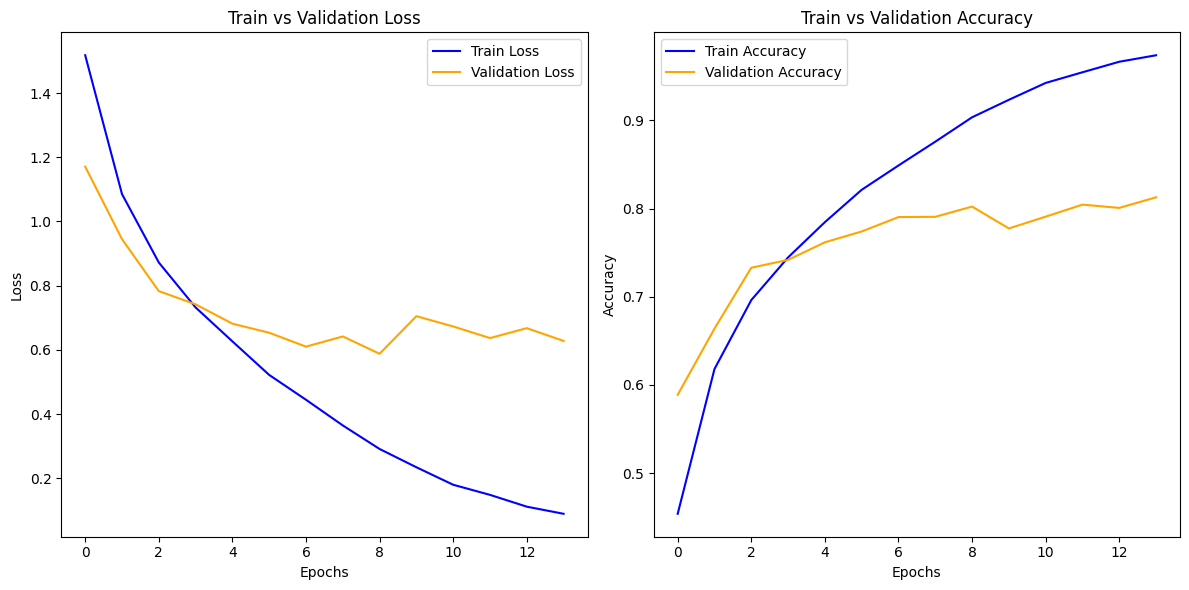

In [13]:
import matplotlib.pyplot as plt
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = len(train_losses)

    # Loss
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_losses, label='Train Loss', color='blue')
    plt.plot(range(epochs), val_losses, label='Validation Loss', color='orange')
    plt.title('Train vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(range(epochs), val_accuracies, label='Validation Accuracy', color='orange')
    plt.title('Train vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)